In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt

from sklearn import metrics
from torchvision import datasets, transforms

# Debugger 
from IPython.core.debugger import set_trace

%matplotlib inline

In [18]:
# Config contains hyperparameter values to be used in the model
config = {
          'batch_size':64,          # Training batch size
          'cuda': {'use_cuda':False,  # Use_cuda=True: use GPU
                   'device_idx': 0}, # Select gpu index: 0,1,2,3
          'log_interval':100,         # How often to dislay (batch) loss during training
          'epochs': 1000,              # Number of epochs
          'learningRate': 0.001,     # learning rate to the optimizer
          'momentum': 0.9,            # momentum in the SGD optimizer
          'use_augmentation': True,  # Use augmentation
          'weight_decay': 0.0001     # weight_decay value
         }

In [3]:
# Transformation on the data
# If use_augmentation is set to True, randomcropping and horizontal flips are used
# else, we only transform to torch tensors and normalize with standard variables

if config['use_augmentation']:
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), 
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
else:
    train_transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
    
print(train_transform)
print(val_transform)


Compose(
    RandomCrop(size=(32, 32), padding=4)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
)
Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
)


In [4]:
data_path        = './data'

train_data       = datasets.CIFAR10(root=data_path, download=True, train=True, transform=train_transform)
val_data         = datasets.CIFAR10(root=data_path, download=True, train=False, transform=val_transform)

train_dataloader = torch.utils.data.DataLoader(dataset=train_data, batch_size=config['batch_size'], shuffle=True, num_workers=2)
val_dataloader   = torch.utils.data.DataLoader(dataset=val_data, batch_size=config['batch_size'], shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


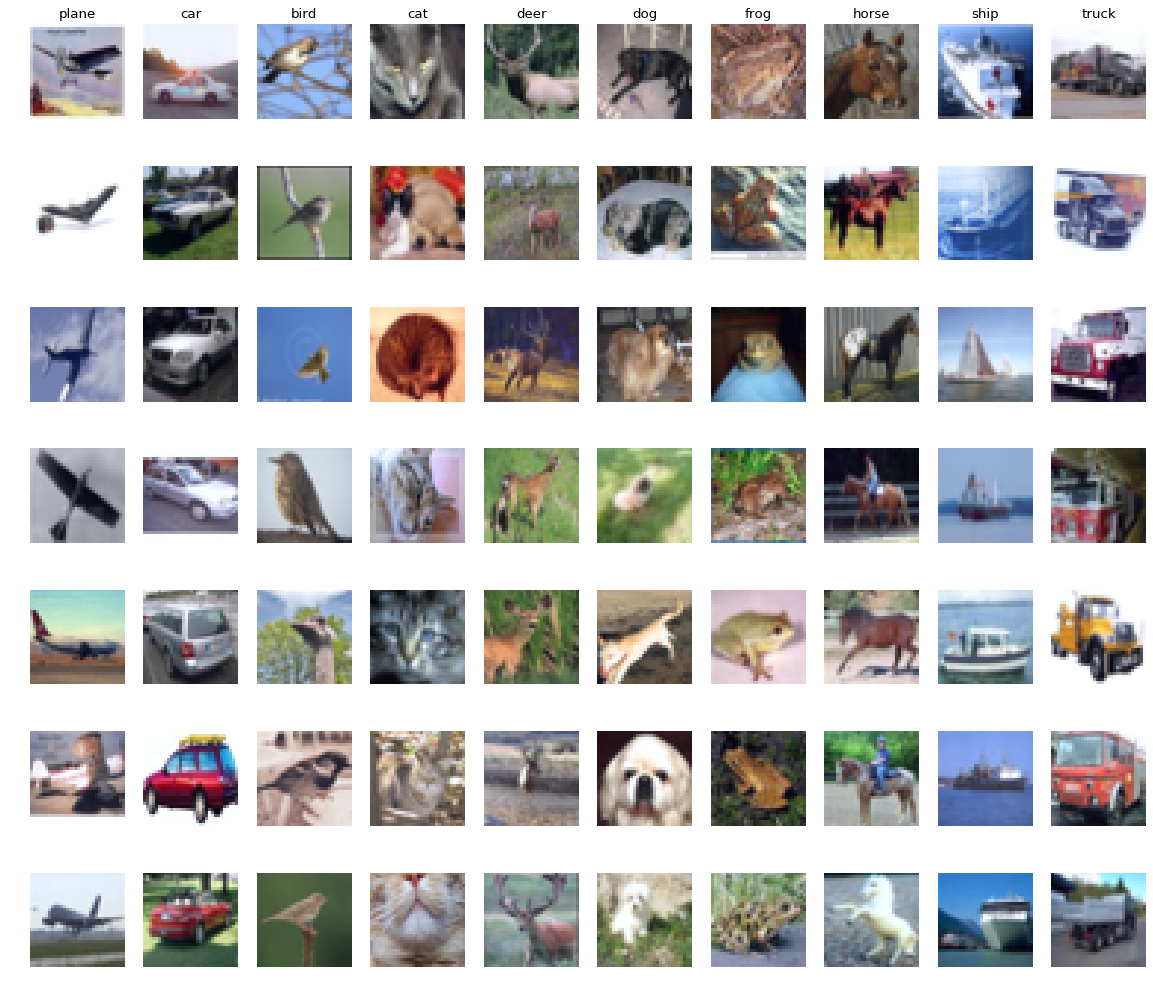

In [5]:
# Visualize a sample of random images

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
plt.figure(figsize=(18, 16), dpi=80)
labels = np.array([x[1] for x in val_data])

for y, cls in enumerate(classes):              
    idxs = np.flatnonzero(labels == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        img = (val_data[idx][0]*0.2 + 0.5)*255
        img = img.permute(1, 2, 0).numpy()
        img = np.minimum(img, 255)
        plt.imshow(img.astype(np.uint8))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
# torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)

# wout = ((win - F + 2P) / S ) + 1

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        # in_channels = 3, out_channels = 18
        # Size = 32x32
        self.conv1 = nn.Conv2d(3, 12, kernel_size=3, stride=1, padding=1)
        
        # channels = same, 
        # Size = 16x16
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # in_channels = 18, out_channels = 32
        # Size = 16x16
        self.conv2 = nn.Conv2d(12, 32, kernel_size=3, stride=1, padding=1)
        
        #channels = same, 
        # Size = 8x8
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        
        # Input features = 1024
        # Output features = 128
        self.fc1   = nn.Linear(8 * 8 * 32, 128)
        
        self.fc2   = nn.Linear(128, 64)
        
        self.fc3   = nn.Linear(64, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        
        x = F.relu(self.fc2(x))
        
        x = F.relu(self.fc3(x))
        
        return x
        
        

In [12]:
model = NeuralNetwork()

def cost(predicted, labels):
        loss = F.cross_entropy(input=predicted, target=labels)
        return loss
        

In [14]:
optimizer = optim.SGD(model.parameters(), lr = config['learningRate'], momentum = config['momentum'])

def run_epoch(model,epoch , data_loader, optimizer, is_training, config):
    
    if is_training:
        model.train()
    else:
        model.eval()
    
    total_loss = 0
    correct    = 0
    
    for batch_idx, data_batch in enumerate(data_loader):
        
        # data_batch returns a tuple, first element is data, second is label
        image  = data_batch[0]
        label = data_batch[1]
        
        if not is_training:
            with torch.no_grad():
                
                predicted  = model.forward(image)
                loss       = cost(predicted, label)
                
                total_loss+= loss.item()
                
        elif is_training:
            
            predicted      = model.forward(image)
            loss           = cost(predicted, label)
            total_loss    += loss.item()
            
            # Null out the gradients, calculate new gradients in backpropagaton and step with SGD
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        
        predicted_label = predicted.max(1, keepdim=True)[1][:, 0]
        correct        += predicted_label.eq(label).cpu().sum().numpy()

        batchSize = len(labels)
        if batch_idx % config['log_interval'] == 0:
            print('Epoch: {}\nLoss: {}'.format(epoch, loss))
            print(f'Epoch={epoch} | {batch_idx/len(data_loader)*100:.2f}% | loss = {loss/batchSize:.5f}')
            
            
    
    loss_avg = total_loss / len(data_loader)
    accuracy = correct / len(data_loader.dataset)
        
    return loss_avg, accuracy

In [2]:
# training the model
train_loss = np.zeros(shape=config['epochs'])
train_acc  = np.zeros(shape=config['epochs'])
val_loss   = np.zeros(shape=config['epochs'])
val_acc    = np.zeros(shape=config['epochs'])


for epoch in range(config['epochs']):
    
    train_loss[epoch], train_acc[epoch] = run_epoch(model, epoch, train_dataloader, optimizer, is_training=True, config=config)
    val_loss[epoch], val_acc[epoch] = run_epoch(model, epoch, val_dataloader, optimizer, is_training=False, config=config)
    

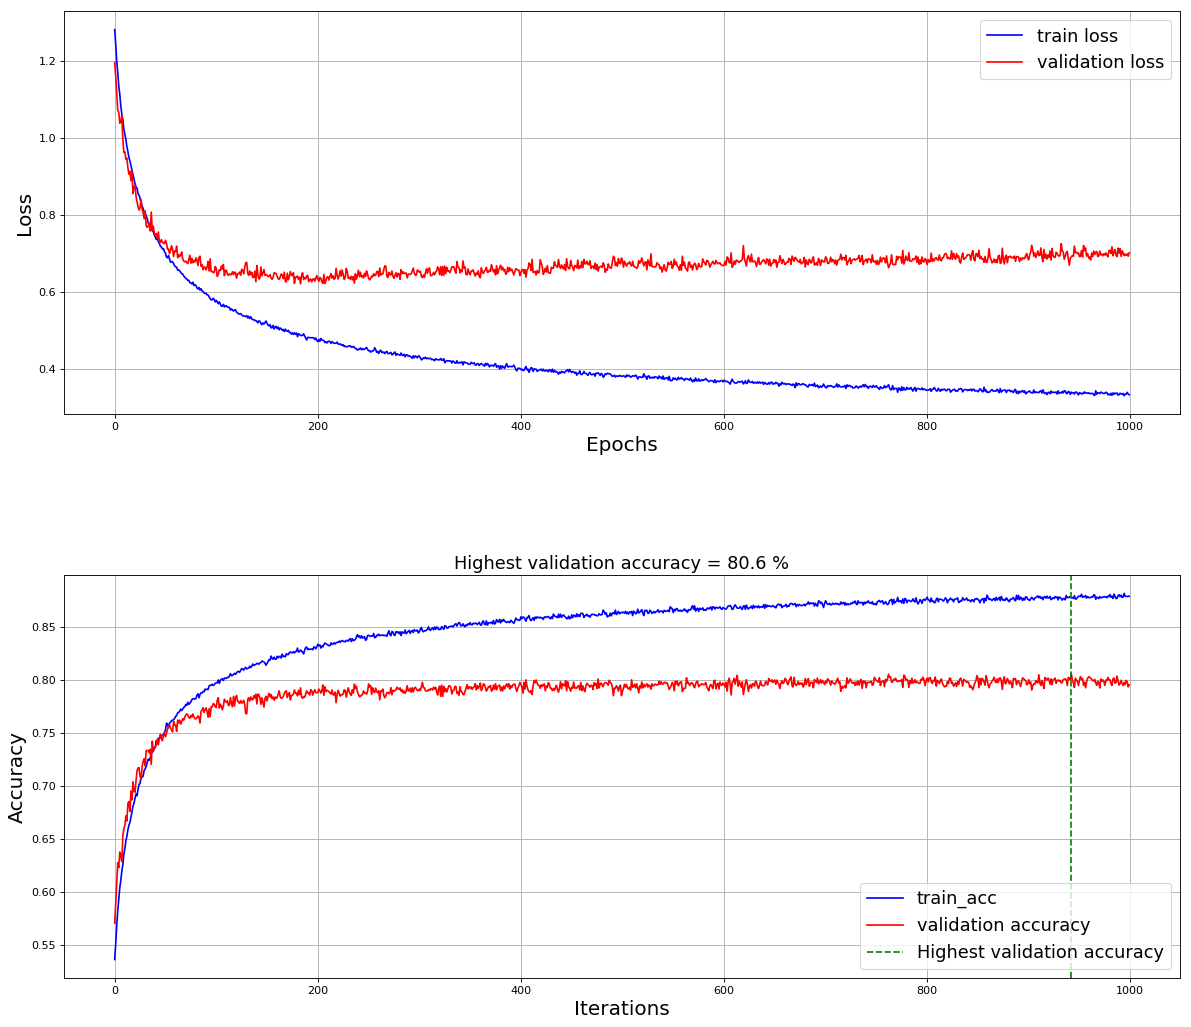

In [20]:
# Plot the training accuracy and the training loss
#plt.figure()
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(2, 1, 1)
# plt.subplots_adjust(hspace=2)
ax.plot(train_loss, 'b', label='train loss')
ax.plot(val_loss, 'r', label='validation loss')
ax.grid()
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
ax.legend(loc='upper right', fontsize=16)

ax = plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=0.4)
ax.plot(train_acc, 'b', label='train_acc')
ax.plot(val_acc, 'r', label='validation accuracy')
ax.grid()
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Iterations', fontsize=18)
val_acc_max = np.max(val_acc)
val_acc_max_ind = np.argmax(val_acc)
plt.axvline(x=val_acc_max_ind, color='g', linestyle='--', label='Highest validation accuracy')
plt.title('Highest validation accuracy = %0.1f %%' % (val_acc_max*100), fontsize=16)
ax.legend(loc='lower right', fontsize=16)
plt.ion()

# TODO
#
# Seems to be overfitting
# Include dropout
# Increase dimentions and n_filters